In this notebook, we explore how the learning and memory can be driven by curiosity, confidence level and timeloss memory. Everytime a source is reached, a new source is chosen as the next target based on a table associated to the fly; in this table, the confidence level of how well the fly knows all the sources is stored. This confidence level decreases with time; everytime a source is reached, this value decreases for each sources; if its negative, it is set equal to zero.

After this first explaration, we want the fly to be able to walk to the different sources based on its internal state; the mating state and the food stock levels (AAs level) will guide its exploration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
from pathlib import Path
from tqdm import trange
from flygym.mujoco import Parameters
from flygym.mujoco.examples.turning_controller import HybridTurningNMF
from flygym.mujoco.arena import OdorArena

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array(
    [[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5], [12, -8, 1.5], [20, 3, 1.5]]
)

# Peak intensities: array of shape (num_odor_sources, odor_dimesions)
peak_intensity = np.array([[2, 3], [3, 7], [1, 3], [5, 3], [1, 3]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [
    [255, 127, 14],
    [31, 119, 180],
    [255, 192, 203],
    [255, 0, 0],
    [0, 255, 0],
]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimesions = len(peak_intensity[0])

odor_valence = [1, 10, 12, 17, 20]

logging.basicConfig(level=logging.INFO)

(-0.5, 799.5, 607.5, -0.5)

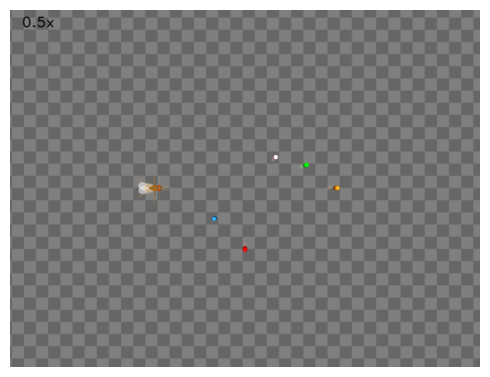

In [2]:
# Set up the arena
arena = OdorArena(
    odor_source=odor_source,
    size=(50, 50),
    peak_intensity=peak_intensity,
    odor_valence=odor_valence,
    diffuse_func=lambda x: x**-2,
    marker_size=0.3,
    marker_colors=marker_colors,
    key_angle=True,  # we add this boolean so that we compute the key for the valence dictionary by using the angle formed in the complex plane
)

# Add the NeuroMechFLy

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    simulation_time=140,
)
# odor_score_reach_addition=2,
# odor_score_time_loss=1
for i in range(1):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")

In [3]:
# Let's start the simulation
decision_interval = 0.01
run_time = 40  # sim.simulation_time / 2
num_decision_steps = int(run_time / decision_interval)
logging.info("Number of decision steps: ", num_decision_steps)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)
logging.info("Physics steps per decision step: ", physics_steps_per_decision_step)

obs_hist = []
odor_history = []
obs, _ = sim.reset()

# Let's choose the source towards which the fly will walk
source = sim.choose_odor_exploration()
prev_reward = None
logging.info("Going to the source ", source + 1)

# Let's start the exploration
for i in trange(num_decision_steps):
    # compute the control signal to go towards the chosen source
    control_signal = arena.generate_specific_turning_control(source, sim)
    for _ in range(physics_steps_per_decision_step):
        obs, reward, terminated, truncated, _ = sim.step(control_signal, False, True)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)

        if reward != None:
            # let's check if the fly has actually reached a new source
            if prev_reward != reward:
                # if it has, the sim.odor_scores is updated and a new source to be reached is computed
                sim.update_odor_scores(source)
                sim.update_odor_scores_key(source)
                source = sim.choose_odor_exploration()
                logging.info("new source", source + 1)
                logging.info(sim.odor_scores)
                prev_reward = reward
        if terminated:
            logging.info("Out of time")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break
        if truncated:
            logging.info("No food source was reached, simulation is truncated")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break

  4%|▍         | 171/4000 [00:53<19:53,  3.21it/s]


KeyboardInterrupt: 

In [4]:
# Let's check the confidence level for the fly's memory related to the different sources
print(sim.odor_scores)
# Let's check the fly's memory
print(sim.fly_valence_dictionary)
print(arena.valence_dictionary)

print(sim.key_odor_scores)

[ 0. 15.  0.  0.]
{0.4048917862850834: 10}
{0.5880026035475675: 1, 0.4048917862850834: 10, 0.32175055439664224: 20, 1.0303768265243125: 17}
{0.5880026035475675: 0, 0.4048917862850834: 14.0, 0.32175055439664224: 0, 1.0303768265243125: 0}


In [5]:
# Choose a name to save both the video and the trajectory
name = "angle_counting_based_simulation_internal_nordm"
path = Path(f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}")
os.mkdir(path)

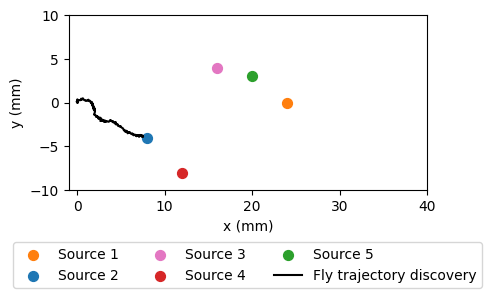

In [6]:
# Plot the trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Source 1",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Source 2",
)
ax.scatter(
    [odor_source[2, 0]],
    [odor_source[2, 1]],
    marker="o",
    color="tab:pink",
    s=50,
    label="Source 3",
)
ax.scatter(
    [odor_source[3, 0]],
    [odor_source[3, 1]],
    marker="o",
    color="tab:red",
    s=50,
    label="Source 4",
)
ax.scatter(
    [odor_source[4, 0]],
    [odor_source[4, 1]],
    marker="o",
    color="tab:green",
    s=50,
    label="Source 5",
)
ax.plot(
    fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory discovery"
)
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory.png"
)

In [7]:
# save the video
sim.save_video(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_video_exploration.mp4"
)

In [16]:
truncated = False

In [31]:
# In order for the fly to walk around the arena based on its internal state, it must have visited all the sources before
if not (sim.all_sources_explored()):
    # The fly is respawned
    obs, _ = sim.respawn()
    # Let the exploration begin

    decision_interval = 0.01
    run_time = sim.simulation_time / 2
    num_decision_steps = int(run_time / decision_interval)
    logging.info("Number of decision steps: ", num_decision_steps)
    physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)
    logging.info("Physics steps per decision step: ", physics_steps_per_decision_step)

    _obs_hist = []
    _odor_history = []

    # Bool to see if simulation is done
    sim_end = False
    # Get fly's hunger state
    hunger_limits = sim.food_requirements
    # To keep track of the previous internal state
    prev_int_state = ""

    prev_reward = None
    source = None
    # Run simulation
    # For each decision step

    for i in trange(num_decision_steps):
        if not (sim_end):
            # Check where the fly's hunger level is at
            int_state = sim.compute_internal_state()
            # Change gains for the exploration only if the internal state has changed
            # Compute bias from odor intensity & control signal
            if int_state == "starving":
                # the fly will reach the closest source
                source = sim.compute_closest_source(obs)
            elif int_state == "hungry":
                # the fly will reach the source that is the highest reward
                source = arena.compute_richest_closest_source(obs)
            else:
                if source == None:
                    # the fly will decide which source to go to based on its internal table
                    source = sim.choose_angle_key_odor_exploration()
                    print(source)

            control_signal = arena.generate_specific_turning_control(source, sim)
            # Make environment step and reward fly if it gets to a food source
            for _ in range(physics_steps_per_decision_step):
                obs, reward, terminated, truncated, _ = sim.step(
                    control_signal, False, True
                )
                rendered_img = sim.render(True)
                if rendered_img is not None:
                    # record odor intensity too for video
                    _odor_history.append(obs["odor_intensity"])
                _obs_hist.append(obs)

                # If fly gets to food source, simulation does not end
                # fly keeps walking based on its internal state
                if reward != None:
                    if prev_reward != reward:
                        # sim_end = True
                        sim.update_odor_scores_key(source)
                        source_reward = sim.compute_closest_source(obs)
                        logging.info("Fly got to food source", source_reward)
                        logging.info("Elapsed time in the simulation", sim.curr_time)
                        prev_reward = reward
                        print(reward)
                        source = None
                        print(int_state)
                        break
                    # break
                # If fly has no food left, end simulation (death)
                # if obs["food_stocked"] < 0:
                #    sim_end = True
                #    logging.info("Fly died")
                #    break

                # If simulation should be terminated or truncted, end simulation
                if terminated:
                    logging.info("Out of time")
                    logging.info("Elapsed time in the simulation", sim.curr_time)
                    sim_end = True
                    break
                if truncated:
                    logging.info("No food source was reached, simulation is truncated")
                    logging.info("Elapsed time in the simulation", sim.curr_time)
                    sim_end = True
                    break

  0%|          | 0/7000 [00:00<?, ?it/s]

2


  4%|▎         | 253/7000 [01:23<34:38,  3.25it/s]

20
3


  6%|▌         | 414/7000 [02:11<32:37,  3.36it/s]

In [28]:
# In order for the fly to walk around the arena based on its internal state, it must have visited all the sources before
if sim.all_sources_explored():
    # The fly is respawned
    obs, _ = sim.respawn()
    # Let the exploration begin

    decision_interval = 0.01
    run_time = sim.simulation_time / 2
    num_decision_steps = int(run_time / decision_interval)
    logging.info("Number of decision steps: ", num_decision_steps)
    physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)
    logging.info("Physics steps per decision step: ", physics_steps_per_decision_step)

    _obs_hist = []
    _odor_history = []

    # Bool to see if simulation is done
    sim_end = False
    # Get fly's hunger state
    hunger_limits = sim.food_requirements
    # To keep track of the previous internal state
    prev_int_state = ""

    prev_reward = None
    source = None
    # Run simulation
    # For each decision step
    for i in trange(num_decision_steps):
        if not sim_end:
            # Check where the fly's hunger level is at
            int_state = sim.compute_internal_state()
            # Change gains for the exploration only if the internal state has changed
            # Compute bias from odor intensity & control signal
            if int_state == "starving":
                # the fly will reach the closest source
                closest_source = sim.compute_closest_source(obs)
                control_signal = arena.generate_specific_turning_control(
                    closest_source, sim
                )
                if source != closest_source:
                    source = closest_source
                    print(source)
            elif int_state == "hungry":
                # the fly will reach the source that is the highest reward
                richest_source = arena.compute_richest_closest_source(obs)
                control_signal = arena.generate_specific_turning_control(
                    richest_source, sim
                )
            else:
                # the fly will decide which source to go to based on its internal table
                source = sim.choose_angle_key_odor_exploration()
                control_signal = arena.generate_specific_turning_control(source, sim)

            # Make environment step and reward fly if it gets to a food source
            for _ in range(physics_steps_per_decision_step):
                obs, reward, terminated, truncated, _ = sim.step(
                    control_signal, False, True
                )
                rendered_img = sim.render(True)
                if rendered_img is not None:
                    # record odor intensity too for video
                    _odor_history.append(obs["odor_intensity"])
                _obs_hist.append(obs)

                # If fly gets to food source, simulation does not end
                # fly keeps walking based on its internal state
                if reward != None:
                    if prev_reward != reward:
                        # sim_end = True
                        sim.update_odor_scores_key(source)
                        source_reward = sim.compute_closest_source(obs)
                        logging.info("Fly got to food source", source_reward)
                        logging.info("Elapsed time in the simulation", sim.curr_time)
                        prev_reward = reward
                        print(reward)
                        break
                    # break
                # If fly has no food left, end simulation (death)
                # if obs["food_stocked"] < 0:
                #    sim_end = True
                #    logging.info("Fly died")
                #    break

                # If simulation should be terminated or truncted, end simulation
                if terminated:
                    logging.info("Out of time")
                    logging.info("Elapsed time in the simulation", sim.curr_time)
                    sim_end = True
                    break
                if truncated:
                    logging.info("No food source was reached, simulation is truncated")
                    logging.info("Elapsed time in the simulation", sim.curr_time)
                    sim_end = True
                    break

  0%|          | 0/7000 [00:00<?, ?it/s]

  6%|▌         | 421/7000 [02:31<40:07,  2.73it/s]

20


 14%|█▍        | 970/7000 [05:18<33:01,  3.04it/s]


KeyboardInterrupt: 

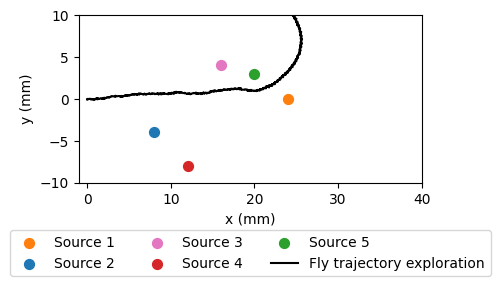

In [29]:
# Plot the trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in _obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Source 1",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Source 2",
)
ax.scatter(
    [odor_source[2, 0]],
    [odor_source[2, 1]],
    marker="o",
    color="tab:pink",
    s=50,
    label="Source 3",
)
ax.scatter(
    [odor_source[3, 0]],
    [odor_source[3, 1]],
    marker="o",
    color="tab:red",
    s=50,
    label="Source 4",
)
ax.scatter(
    [odor_source[4, 0]],
    [odor_source[4, 1]],
    marker="o",
    color="tab:green",
    s=50,
    label="Source 5",
)
ax.plot(
    fly_pos_hist[:, 0],
    fly_pos_hist[:, 1],
    color="k",
    label="Fly trajectory exploration",
)
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory_respawn.png"
)

In [ ]:
sim.save_video(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_video_respawn_internal_state.mp4"
)

In [ ]:
# Plot the trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
_fly_pos_hist = np.array([obs["fly"][0, :2] for obs in _obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Source 1",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Source 2",
)
ax.scatter(
    [odor_source[2, 0]],
    [odor_source[2, 1]],
    marker="o",
    color="tab:pink",
    s=50,
    label="Source 3",
)
ax.scatter(
    [odor_source[3, 0]],
    [odor_source[3, 1]],
    marker="o",
    color="tab:red",
    s=50,
    label="Source 4",
)
ax.scatter(
    [odor_source[4, 0]],
    [odor_source[4, 1]],
    marker="o",
    color="tab:green",
    s=50,
    label="Source 5",
)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Discovering phase")
ax.plot(_fly_pos_hist[:, 0], _fly_pos_hist[:, 1], color="r", label="Exploration phase")
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory_respawn.png"
)